In [1]:
import warnings
import datetime
import itertools
import numpy as np
import scipy as sp
import cvxpy as cp
import pandas as pd
import yfinance as yf
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from functools import reduce
from kit import get_yf_ts, get_mcap

warnings.filterwarnings('ignore')

<b>Volatility $\sigma$</b> is a measure of variation of asset returns over time. It is defined as the standard deviation of a sequence of random variables, each of which is the log return of the asset over the defined time period
$$ \sigma_T = \sigma \sqrt{T},$$ for $\sigma_T$ being the annualized volatility.

This measure of riskiness is typically assessed on annual basis, hence the scaling factor of $\sqrt{T}$. In this context $T$ refers not to the period of measurement, rather the frequenecy of the measures. If the frequency of the measurements (data) is lower, the returns will move more, since the price has more time to move more between samples, resulting in higher standard deviation.

Regardless of the frequency, the final return in the period is the sum of the intermediate changes (product of returns). The sum of an i.i.d. $X$ is a random variable $Y$ whose variance is $T\text{Var}(X)$ for $T$ steps sum, thus the volatility being $\sqrt{T\text{Var}(X)}$.

One can think of this as a normalization factor, where lower frequency data has a larger multiplier and vice-versa, to bring the riskiness (volatility) measure comparible at an annual level.

In [107]:
aapl_d, aapl_m = get_yf_ts('AAPL', '1y', '1d'), get_yf_ts('AAPL', '1y', '1mo')
aapl_returns_d, aapl_returns_m = (1 + np.log(aapl_d['AAPL'] / aapl_d['AAPL'].shift(1))), (1 + np.log(aapl_m['AAPL'] / aapl_m['AAPL'].shift(1)))

In [111]:
aapl_d_vol, aapl_m_vol = np.round(aapl_returns_d.std() * np.sqrt(252), 3), np.round(aapl_returns_m.std() * np.sqrt(12), 3)

In [112]:
print("AAPL annualized volatility from daily returns {} and from monthly returns {}".format(aapl_d_vol, aapl_m_vol))

AAPL annualized volatility from daily returns 0.227 and from monthly returns 0.238


Below we observe the annualized 21 trading day historical volatility of AAPL, 2005 onwards:

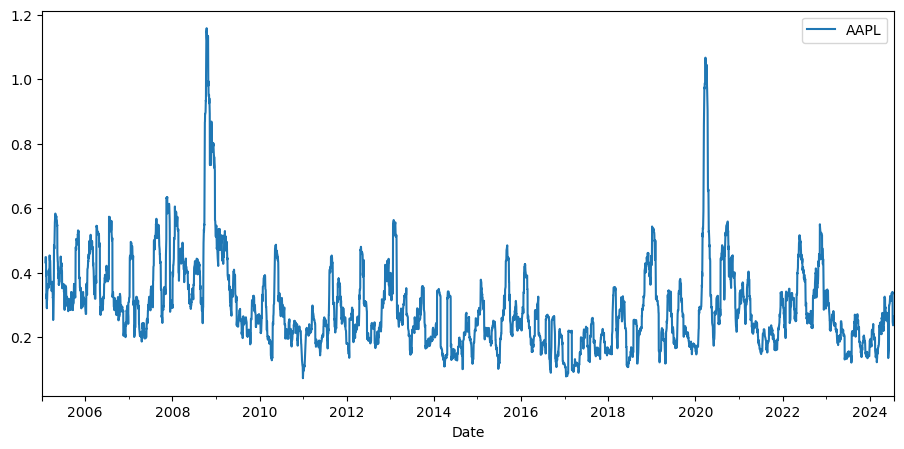

In [118]:
((1 + get_yf_ts('AAPL', 'max', '1d')['2005':].pct_change()).rolling(21).std() * np.sqrt(252)).plot(figsize=(11,5))
plt.show()

To be continued: implied volatility, volatility surfaces and volatility indices

<AxesSubplot:xlabel='strike', ylabel='impliedVolatility'>

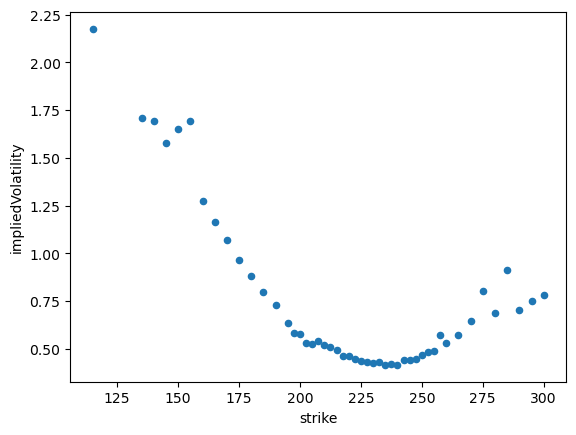

In [91]:
yf.Ticker('AAPL').option_chain()[0][['strike', 'impliedVolatility']].plot.scatter(x='strike', y='impliedVolatility')